<a href="https://colab.research.google.com/github/lim-jr/ESAA/blob/main/1111%EA%B8%88%EA%B3%BC%EC%A0%9C_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_%EC%99%84%EB%B2%BD%EA%B0%80%EC%9D%B4%EB%93%9C(201_211).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 결정트리 실습  
  - 사용자 행동 인식 데이터 세트

In [6]:
## 1. 데이터셋 준비 
## 1-1. 다운로드하고 불러오기

import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

# features.txt 파일에는 피처 이름 index와 피처명이 공백으로 분리되어 있음. 이를 DF로 로드
feature_name_df = pd.read_csv("/content/drive/MyDrive/PyColab_ESAA/데이터셋/features.txt", sep='\s+', 
                              header=None, names=['column_index', 'column_name'])
# 피처명 index를 제거하고, 피처명만 리스트 객체로 생성한 뒤 샘플로 10개만 추출
#feature_name = feature_name_df.drop(['column_index'], axis=1) : 리스트가 아님
feature_name = feature_name_df.iloc[:,1].values.tolist()
print('전체 피처명에서 10개만 추출:', feature_name[:10])

전체 피처명에서 10개만 추출: ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']


* 데이터셋의 피처명 분석  
1) 인체의 움직임과 관련된 속성의 평균/표준편차가 X,Y,Z축으로 돼있음을 유추할 수 있음  
2) 중복된 피처명을 가지는 케이스 있는데, 원본에 _1, _2를 추가하여 오류가 발생하지 않도록  

In [11]:
## 1-2. 전처리

# 중복된 피처명이 얼마나 있는지 알아보기
feature_dup_df = feature_name_df.groupby('column_name').count()
print(feature_dup_df.head(5))

print(feature_dup_df[feature_dup_df['column_index']>1].head(5))
print(feature_dup_df[feature_dup_df['column_index']>1].count())

                                      column_index
column_name                                       
angle(X,gravityMean)                             1
angle(Y,gravityMean)                             1
angle(Z,gravityMean)                             1
angle(tBodyAccJerkMean),gravityMean)             1
angle(tBodyAccMean,gravity)                      1
                              column_index
column_name                               
fBodyAcc-bandsEnergy()-1,16              3
fBodyAcc-bandsEnergy()-1,24              3
fBodyAcc-bandsEnergy()-1,8               3
fBodyAcc-bandsEnergy()-17,24             3
fBodyAcc-bandsEnergy()-17,32             3
column_index    42
dtype: int64


* 그룹화해서 개수 세어봤을 때  
* 42개의 피처명이 중복돼어 있음. 

In [25]:
# 중복된 피처명에 대해서 원본 피처명에 _1, _2를 추가로 부여

def get_new_feature_name_df(old_feature_name_df):
  feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                columns=['dup_cnt'])
  feature_dup_df = feature_dup_df.reset_index()
  new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
  new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 
                                                             'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1])
                                                             if x[1]>0 else x[0], axis=1)
  new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
  return new_feature_name_df

In [27]:
# 1-3. 학습용 데이터, 테스트용 데이터 준비

import pandas as pd

def get_human_dataset():
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백문자를 sep으로 할당
    feature_name_df = pd.read_csv('/content/drive/MyDrive/PyColab_ESAA/데이터셋/features.txt', sep='\s+',
                                                     header=None, names=['column_index', 'column_name'])
    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame 생성
    new_feature_name_df = get_new_feature_name_df(feature_name_df)

    # 데이터프레임에 피처명을 컬럼으로 뷰여하기 위해 리스트 객체로 다시 반환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터세트와 테스트 피처 데이터를 데이터프레임으로 로딩
    # 컬럼명은 feature_name 적용
    X_train = pd.read_csv('/content/drive/MyDrive/PyColab_ESAA/데이터셋/train/X_train.txt', sep='\s+', names=feature_name)
    X_test = pd.read_csv('/content/drive/MyDrive/PyColab_ESAA/데이터셋/test/X_test.txt', sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터를 데이터 프레임으로 로딩, 컬럼명은 action으로 부여
    y_train = pd.read_csv('/content/drive/MyDrive/PyColab_ESAA/데이터셋/train/y_train.txt', sep='\s+', names=['action'])
    y_test = pd.read_csv('/content/drive/MyDrive/PyColab_ESAA/데이터셋/test/y_test.txt', sep='\s+', names=['action'])
    
    # 로드된 학습/테스트용 데이터프레임을 모두 반환
    return X_train, X_test, y_train, y_test

# 학습/테스트용 데이터 프레임 반환
X_train, X_test, y_train, y_test = get_human_dataset()

In [34]:
print('## 학습용 피처 데이터셋 info()')
print(X_train.info())
X_train.head(3)

## 학습용 피처 데이터셋 info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB
None


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118


In [32]:
y_train.value_counts()

action
6         1407
5         1374
4         1286
1         1226
2         1073
3          986
dtype: int64

* 학습용 피처 데이터셋 분석  
1) 7352개의 행(레코드), 561개의 열(피처)을 가짐  
2) 피처(X칼럼)의 대부분이 움직임 위치와 관련된 속성  
3) 레이블 값 (Y칼럼)dms 1,2,3,4,5,6 6개의 값이고 고르게 분포  

In [36]:
## 2. 동작 예측분류 수행하기 
## 2-1. 하이퍼 파라미터 모두 디폴트값으로 

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# 예제 반복 시마다 동일한 예측 결과 도출을 위해 random_state 설정
dt_clf=DecisionTreeClassifier(random_state=156)
dt_clf.fit(X_train, y_train)
pred = dt_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('결정트리 예측 정확도: {0:.4f}'.format(accuracy))

# DecisionTreeClassifier의 하이퍼 파라미터 추출
print('DecisionTreeClassifier 기본 하이퍼 파라미터:\n', dt_clf.get_params())

결정트리 예측 정확도: 0.8548
DecisionTreeClassifier 기본 하이퍼 파라미터:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 156, 'splitter': 'best'}


* 예측분류 결과 분석  
1) 85.48%의 정확도   

In [37]:
## 2-2. 결정트리의 트리깊이가 예측 정확도에 주는 영향 

from sklearn.model_selection import GridSearchCV

# 결정트리의 깊이를 조절할 수 있는 하이퍼 파라미터인 max_depth 값을 변화시키면서 예측성능 확인
params = {
    'max_depth':[6,8,10,12,16,20,24]
}

# 교차 검증은 5개의 세트, 하이퍼파라미터 중 max_depth 값 조절
grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(X_train, y_train)
print('GridSearchCV 최고 평균 정확도 수치: {0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:', grid_cv.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
GridSearchCV 최고 평균 정확도 수치: 0.8513
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 16}


* 트리깊이 조절했을 때, 예측분류 결과 분석  
1) 최적 하이퍼 파라미터에서 85.13%의 정확도  
2) 최적 하이퍼 파라미터 값은 트리깊이 16  

   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       2.404723      0.414585         0.009091        0.000611   
1       2.718655      0.065116         0.008244        0.000229   
2       3.457823      0.474046         0.009517        0.002131   

  param_max_depth             params  split0_test_score  split1_test_score  \
0               6   {'max_depth': 6}           0.813732           0.872876   
1               8   {'max_depth': 8}           0.820530           0.819850   
2              10  {'max_depth': 10}           0.799456           0.814412   

   split2_test_score  split3_test_score  split4_test_score  mean_test_score  \
0           0.819728           0.865986           0.881633         0.850791   
1           0.855102           0.868707           0.891156         0.851069   
2           0.863265           0.891156           0.887755         0.851209   

   std_test_score  rank_test_score  
0        0.028313                5  
1        0.027719          

([<matplotlib.axis.XTick at 0x7fdcf8d8e950>,
 <a list of 7 Text major ticklabel objects>)

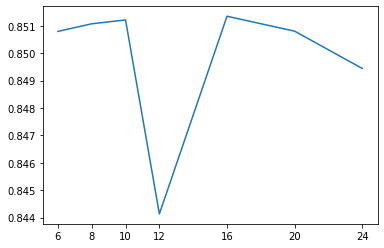

In [47]:
## 2-3. 5개의 cv세트에서 max_depth값에 따라 어떻게 예측 성능이 변했는지 살펴보기

# GridSearchCV 객체의 cv_results_ 속성은 CV셑트에 하이퍼 파라미터를 순차적으로 입력했을 때의 성능 수치를 저장해놓음
cv_results_df = pd.DataFrame(grid_cv.cv_results_)

# max_depth 파라미터 값과 그때의 테스트셋, 학습 데이터세스이 정확도 수치 추출
print(cv_results_df.head(3))
print(cv_results_df[['param_max_depth', 'mean_test_score']])
plt.plot(cv_results_df['param_max_depth'], cv_results_df['mean_test_score'])
plt.xticks([6,8,10,12,16,20,24])

* 트리깊이별 평균 정확도 분석  
1) max_depth가 16일때 정확도가 0.851344  

max_depth=6 정확도: 0.8558
max_depth=8 정확도: 0.8707
max_depth=10 정확도: 0.8673
max_depth=12 정확도: 0.8646
max_depth=16 정확도: 0.8575
max_depth=20 정확도: 0.8548
max_depth=24 정확도: 0.8548


([<matplotlib.axis.XTick at 0x7fdcf8ec3710>,
 <a list of 7 Text major ticklabel objects>)

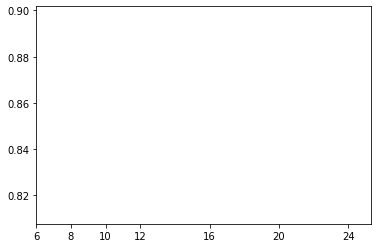

In [46]:
## 3.3 테스트 데이터셋에서 결정트리의 정확도 측정 

max_depths=[6,8,10,12,16,20,24]

# max_depth 값을 변화시키면서, 그때마다 학습과 테스트 데이터셋에서의 예측성능 측정
for depth in max_depths:
  dt_clf = DecisionTreeClassifier(max_depth=depth, random_state=156)
  dt_clf.fit(X_train, y_train)
  pred = dt_clf.predict(X_test)
  accuracy = accuracy_score(y_test, pred)
  print('max_depth={0} 정확도: {1:.4f}'.format(depth, accuracy))

* 학습, 테스트 데이터셋에서 트리깊이별 정확도 분석  
1) max_depth=8일때 가장 높은 정확도   
2) max_depth가 8넘어가면서 정확도 계속 감소  
3) 트리깊이가 깊어질수록 과적합의 영향력이 커지므로 깊이를 제어해야  

In [48]:
## 4. 또다른 파라미터인 min_samples_split를 변경하며 정확도 성능 튜닝

params={
    'max_depth':[8,12,16,20],
    'min_samples_split':[16,24]
}
grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(X_train, y_train)
print('GridSearchCV 최고 평균 정확도 수치: {0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:', grid_cv.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
GridSearchCV 최고 평균 정확도 수치: 0.8549
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 8, 'min_samples_split': 16}


* 결과 분석  
1) max_depth=8, min_samples_split=16일때 가장 최고 정확도  

In [50]:
# 5. max_depth=8, min_samples_split=16 으로 학습이 완료된 모델에 테스트 데이터셋 예측수행

best_df_clf = grid_cv.best_estimator_
pred1 = best_df_clf.predict(X_test)
accuacy= accuracy_score(y_test, pred1)
print('결정트리 예측정확도:{0:.4f}'.format(accuracy))

결정트리 예측정확도:0.8548
